In [ ]:
! pip install tensorflow


^C


In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


In [ ]:
# Load datasets
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

print("Fake news shape:", fake.shape)
print("True news shape:", true.shape)

# Add labels
fake['label'] = 0   # 0 = Fake
true['label'] = 1   # 1 = Real

# Combine datasets
df = pd.concat([fake, true], axis=0).reset_index(drop=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Quick look
df.head()


Fake news shape: (23481, 4)
True news shape: (21417, 4)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [ ]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text', 'label']].head()


,text,clean_text,label
0,"21st Century Wire says Ben Stein, reputable pr...",st century wire says ben stein reputable profe...,0
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters us president donald trump ...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello...,1
3,"On Monday, Donald Trump once again embarrassed...",on monday donald trump once again embarrassed ...,0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters most us presidential...,1


In [ ]:
X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Tokenization parameters
max_words = 5000    # Vocabulary size
max_len = 500       # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print("Training shape:", X_train_pad.shape)
print("Testing shape:", X_test_pad.shape)


Training shape: (35918, 500)
Testing shape: (8980, 500)


In [ ]:
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64
)


Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.9109 - loss: 0.2134 - val_accuracy: 0.9910 - val_loss: 0.0261
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.9881 - loss: 0.0378 - val_accuracy: 0.9928 - val_loss: 0.0205
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9943 - val_loss: 0.0164
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.9978 - loss: 0.0088 - val_accuracy: 0.9957 - val_loss: 0.0140
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9939 - val_loss: 0.0198


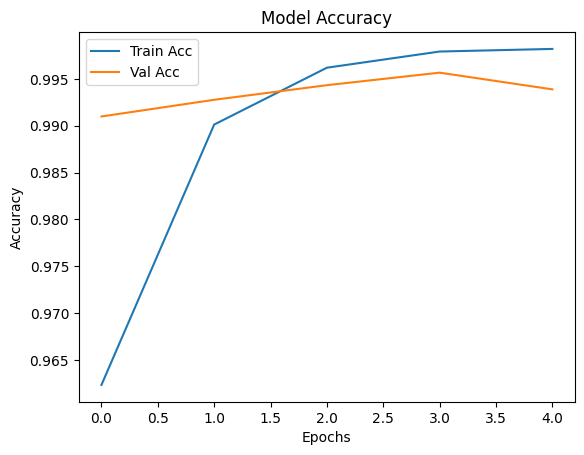

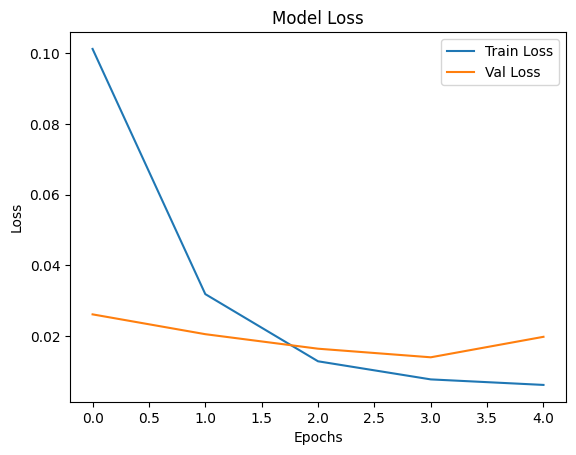

281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4696
           1       1.00      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



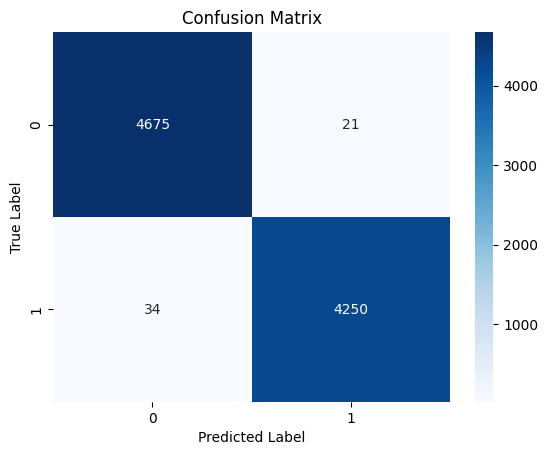

In [ ]:
# Accuracy curve
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Save model
model.save("models/bilstm_model.h5")

# Save tokenizer
import pickle
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
